# ⚙️ [Part III] Classical Benchmarking and Feature Importance

Welcome to the third notebook in Team Quail’s submission for the **FLIQ Hackathon**.

Our project, Quail – Quantum Understanding and AI for Interpretability and Learning – explores how hybrid quantum-classical models and interpretable machine learning can tackle challenging problems in drug discovery.

In this notebook, we establish a **baseline performance benchmark** using a suite of fully classical machine learning models. Our aim is to evaluate how well the prepared molecular descriptor data performs using standard models before exploring more advanced or hybrid approaches.

In this notebook, we will:

- Train and evaluate classical models such as **Logistic Regression** and **Random Forest**.
- Compare performance metrics such as **AUROC**, **F1-score**, and **accuracy** across models.
- Retrieve and visualize **feature importances** to identify which molecular descriptors contribute most to the prediction task.

This benchmark will serve as a critical reference point for any future improvements from quantum or interpretable ML pipelines.


## Data Loading
We will retrieve both the original and the scaled data from Part II.

In [124]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# show all columns
pd.set_option('display.max_columns', None)  

In [105]:
# retrieve data
df_train = pd.read_csv("drug+induced+autoimmunity+prediction/DIA_trainingset_RDKit_descriptors.csv")
df_train.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,6.668,6.668,4.719,4.719,3.241,3.241,6.093,9.185,0.0,35.509,22.291,4.900,20.224,41.210,0.000,24.787,11.467,422.162,0.150,-4.28,31,403.272,1.218475e+07,20.012,7.859,3.564,175.833,14.164,0.452,14.164,0.413,0.018,0.413,-0.668,-0.452,2.443,113.689,422.424,4,10,0,0,0,1,3,4,9,2,11,0,6,0,0,0,158,16.204,17.199,23.107,0.0,0.000,6.093,4.900,28.819,5.099,0.000,18.199,18.199,18.808,19.041,4,13.922,34.450,0.000,24.732,0.000,6.545,30.525,53.976,0,11.518,16.367,26.508,0.0,0.000,44.983,11.282,5.817,5.563,42.595,0.0,22.552,0,138.07,0,0.000,0,0,0,0,0,0,15.727,62.940,0,0,0,2,0,5,0,0,0,0,1,1,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,3.545,4.661,2.449,3.735,1.520,2.621,12.073,10.002,0.0,0.000,5.063,14.963,0.000,18.261,30.332,0.000,5.734,236.062,0.182,-1.59,16,224.200,5.774616e+03,10.912,4.112,1.868,96.858,10.832,0.350,10.832,0.339,0.421,0.339,-0.843,-0.350,2.732,63.449,236.296,3,4,0,0,0,1,1,2,3,2,5,0,3,0,0,0,84,5.734,0.000,0.000,0.0,0.000,6.031,5.207,4.795,5.063,11.337,18.199,24.443,9.577,6.042,2,10.002,27.454,0.000,5.063,5.734,12.966,0.000,35.209,0,0.000,5.734,4.795,0.0,11.337,16.302,0.000,0.000,17.843,30.332,0.0,10.086,0,66.56,0,1.542,0,0,0,0,0,0,0.000,39.292,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.47

In [106]:
# import the test file
df_test = pd.read_csv("drug+induced+autoimmunity+prediction/DIA_testset_RDKit_descriptors.csv")
df_test.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,C[C@H](\C=C\[C@H](O)C1CC1)[C@@H]2CC[C@@H]3\C(=...,1.484,743.207,21.466,18.764,18.764,14.292,12.106,12.106,10.736,10.736,8.532,8.532,6.626,6.626,12.208,15.320,0.0,6.104,41.928,17.567,44.098,0.000,0.000,44.730,0.000,412.298,0.704,-1.16,30,372.294,8.390163e+06,22.049,8.763,4.397,181.829,10.227,0.393,10.227,0.081,0.250,0.081,-0.621,-0.393,5.091,121.760,412.614,3,3,4,0,4,0,0,0,3,3,3,0,5,4,0,4,166,15.320,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,50.304,91.599,6.421,18.312,4,15.320,0.000,0.0,0.000,29.087,89.947,0.000,47.602,0,0.000,0.000,0.000,0.000,0.000,33.631,0.000,29.087,71.635,47.602,0.0,0.0,0,60.69,0,0.000,0,0,0,0,0,0,0.000,62.083,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,OCCN1CCN(CCCN2c3ccccc3Sc4ccc(cc24)C(F)(F)F)CC1,1.472,868.947,21.140,16.736,17.553,14.453,10.268,11.084,7.662,8.746,5.690,6.820,4.077,5.153,11.740,13.171,0.0,6.607,18.777,54.623,23.895,6.066,29.165,9.800,5.107,437.175,0.455,-1.74,30,411.323,6.669991e+06,21.490,9.177,4.771,178.820,13.311,0.416,13.311,0.416,0.186,0.395,-4.351,-0.395,4.308,113.598,437.531,1,4,0,2,2,2,0,2,5,1,8,0,7,0,1,1,162,14.906,0.000,0.000,0.000,0.0,6.176,4.900,0.000,13.171,0.000,23.895,43.297,49.060,23.545,4,18.278,23.137,0.0,9.800,0.000,22.388,57.320,48.028,0,0.000,4.900,24.546,0.000,11.762,67.327,6.176,0.000,11.984,52.256,0.0,0.0,0,29.95,0,1.527,0,0,0,0,0,0,39.932,33.458,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0,2,0,2,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,C[C@@H]1O[C@H](C[C@H](O)[C@@H

In [107]:
# import the scaled train file
df_train_scaled = pd.read_csv("processed_data/DIA_trainingset_scaled.csv")
df_train_scaled.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.452875,1.344465,0.551264,0.395663,0.309064,0.627503,0.204954,0.062833,-0.001312,-0.175467,-0.046856,-0.216005,-0.134956,-0.295263,-0.525136,-0.384981,-0.181361,1.395076,0.554831,-0.812459,0.507059,2.249669,-0.893830,0.593069,0.084085,0.435157,-1.274949,-2.173874,0.428571,0.494435,-0.077296,0.224120,0.054235,-0.073153,0.460355,1.022116,0.090102,1.022116,1.398748,-0.410428,1.551494,0.396527,-0.140761,0.042382,0.514900,0.433896,0.2500,0.434783,0.0,0.0,0.0,0.333333,0.75,0.8,0.473684,0.166667,0.416667,0.0,0.214286,0.0,0.0,0.0,0.385057,0.012270,0.836808,2.541196,-0.54702,-0.461025,0.310042,-0.363430,4.605039,0.582421,-0.362256,-0.293023,-0.790225,0.005257,0.500367,0.444444,-0.350813,1.067887,-0.190321,2.397158,-0.706031,-0.991136,1.069443,0.578333,0.0,1.199439,1.377778,3.798498,-0.496764,-0.536573,0.116134,-0.150281,-0.197533,-1.047197,0.565206,-0.322665,2.851332,0.0,0.972146,0.0,-0.28323,0.0,0.0,0.0,0.0,0.0,0.0,0.466294,0.397726,0.0,0.000,0.000,1.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.857143,0.000000,0.50,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.1,0.0,1.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.090909,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.310322,-0.632257,-0.887194,-0.923257,-0.867786,-0.887752,-0.954128,-0.864476,-0.953691,-0.776947,-0.874703,-0.567973,-0.887579,-0.560062,-0.263887,-0.305248,-0.181361,-1.140124,-0.755872,-0.247407,-0.915263,0.516790,0.771000,-0.948309,-0.452991,-0.848802,-1.152678,0.324123,0.190476,-0.825238,-0.077299,-0.936127,-0.884150,-0.090552,-0.870688,-

In [108]:
# import the scaled test file
df_test_scaled = pd.read_csv("processed_data/DIA_testset_scaled.csv")
df_test_scaled.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.927408,0.011660,0.460791,0.721410,0.632649,0.501249,0.978653,0.824786,1.239251,1.043675,1.343707,1.147872,1.345362,1.150456,-0.257990,0.213746,-0.181361,-0.704323,2.048809,-0.101188,2.186080,-0.862098,-0.893830,1.833223,-0.990161,0.367102,0.841873,0.723430,0.412698,0.266143,-0.077297,0.483836,0.280629,-0.064608,0.561412,-0.463622,-0.515664,-0.463622,-1.666898,0.007270,-1.741508,0.426808,0.446727,1.091291,0.727625,0.366279,0.1875,0.130435,0.8,0.000000,0.571429,0.000000,0.0,0.0,0.157895,0.250000,0.083333,0.0,0.178571,0.8,0.0,0.666667,0.408046,-0.062648,-0.898272,-0.599476,-0.547020,-0.461025,-0.748403,-1.072078,-0.744894,-0.380377,-0.362256,1.198399,2.130903,-0.843029,0.437391,0.444444,-0.255452,-1.275615,-0.190321,-0.929289,2.182529,1.521281,-0.948979,0.337212,0.0,-0.591507,-0.977961,-0.613938,-0.496764,-0.536573,-0.287119,-1.186703,2.052441,1.506471,0.797500,-0.322665,-0.506809,0.0,-0.446922,0.0,-0.283230,0.0,0.0,0.0,0.0,0.0,0.0,-0.484300,0.363815,0.0,0.375,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.944306,0.331971,0.415761,0.388271,0.435039,0.534627,0.488795,0.556540,0.301815,0.447290,0.307258,0.535504,0.230641,0.521344,-0.278435,0.004021,-0.181361,-0.668410,0.287486,1.979562,0.765235,-0.404055,0.706947,-0.338897,-0.511729,0.538736,-0.109551,0.184829,0.412698,0.553767,-0.077298,0.412564,0.384310,-0.060772,0

### Prepare labels 
While it seems like it's going to be messy, the good thing is that the column order is almost identical and all sets share the same labels. 

No need to prepare the scaled DataFrames because they have removed Label and SMILES.

In [109]:
# prepare the classic train and test data
X_train = df_train[df_train.columns[2:]]
X_test = df_test[df_test.columns[2:]]

# prepare the labels
y_train = df_train['Label']
y_test = df_test['Label']

In [110]:
# X_train should be ready to rumble
X_train.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,6.668,6.668,4.719,4.719,3.241,3.241,6.093,9.185,0.0,35.509,22.291,4.900,20.224,41.210,0.000,24.787,11.467,422.162,0.150,-4.28,31,403.272,1.218475e+07,20.012,7.859,3.564,175.833,14.164,0.452,14.164,0.413,0.018,0.413,-0.668,-0.452,2.443,113.689,422.424,4,10,0,0,0,1,3,4,9,2,11,0,6,0,0,0,158,16.204,17.199,23.107,0.0,0.000,6.093,4.900,28.819,5.099,0.000,18.199,18.199,18.808,19.041,4,13.922,34.450,0.000,24.732,0.000,6.545,30.525,53.976,0,11.518,16.367,26.508,0.0,0.000,44.983,11.282,5.817,5.563,42.595,0.0,22.552,0,138.07,0,0.000,0,0,0,0,0,0,15.727,62.940,0,0,0,2,0,5,0,0,0,0,1,1,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,3.545,4.661,2.449,3.735,1.520,2.621,12.073,10.002,0.0,0.000,5.063,14.963,0.000,18.261,30.332,0.000,5.734,236.062,0.182,-1.59,16,224.200,5.774616e+03,10.912,4.112,1.868,96.858,10.832,0.350,10.832,0.339,0.421,0.339,-0.843,-0.350,2.732,63.449,236.296,3,4,0,0,0,1,1,2,3,2,5,0,3,0,0,0,84,5.734,0.000,0.000,0.0,0.000,6.031,5.207,4.795,5.063,11.337,18.199,24.443,9.577,6.042,2,10.002,27.454,0.000,5.063,5.734,12.966,0.000,35.209,0,0.000,5.734,4.795,0.0,11.337,16.302,0.000,0.000,17.843,30.332,0.0,10.086,0,66.56,0,1.542,0,0,0,0,0,0,0.000,39.292,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,3.551,93.092,6.784,5.471,5.471,3.417,2.420,2.420,2.820,2.820,0.603,0.603,0.387,0.387,5.969,9.901,0.0,6.545,4.483,0.000,0.000,21.143,0.000,0.000,0.

## Model training 
In this section, we'll start with the classical dataset for training, and then we move onto the scaled ones.

### Original dataset

In [114]:
# start with logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [115]:
# get predictions
y_preds_lr = lr.predict(X_test)

In [116]:
# plot a confusion matrix
classic_lr_cm = confusion_matrix(y_preds_lr, y_test)
classic_lr_cm

array([[ 0,  0],
       [90, 30]], dtype=int64)

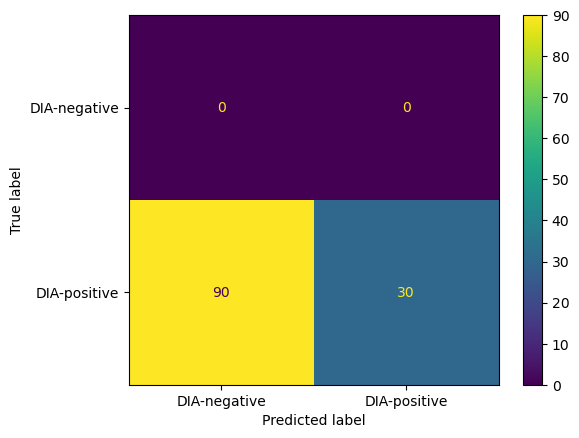

In [117]:
classes = ["DIA-negative", "DIA-positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=classic_lr_cm, display_labels=classes)
disp.plot()

In [118]:
print("f1-score is:", f1_score(y_preds_lr, y_test))
print("accuracy is:", accuracy_score(y_preds_lr, y_test))
print("")
print(classification_report(y_preds_lr, y_test, zero_division=True))

f1-score is: 0.4
accuracy is: 0.25

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.25      0.40       120

    accuracy                           0.25       120
   macro avg       0.50      0.62      0.20       120
weighted avg       1.00      0.25      0.40       120



In [119]:
# continue with random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [120]:
y_preds_rf = rf.predict(X_test)

In [121]:
classic_rf_cm = confusion_matrix(y_preds_rf, y_test)
classic_rf_cm

array([[89, 19],
       [ 1, 11]], dtype=int64)

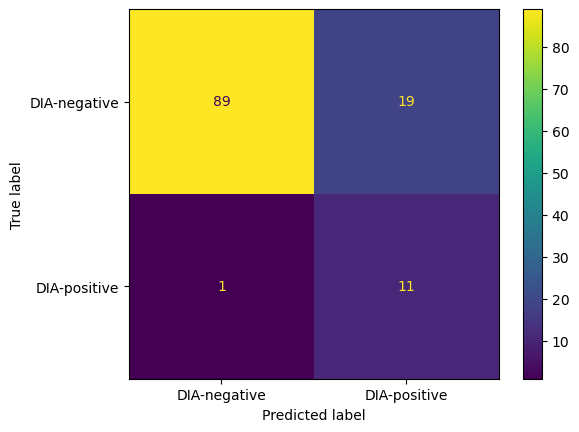

In [122]:
disp = ConfusionMatrixDisplay(confusion_matrix=classic_rf_cm, display_labels=classes)
disp.plot()

In [123]:
print("f1-score is:", f1_score(y_preds_rf, y_test))
print("accuracy is:", accuracy_score(y_preds_rf, y_test))
print("")
print(classification_report(y_preds_rf, y_test))

f1-score is: 0.5238095238095238
accuracy is: 0.8333333333333334

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       108
           1       0.37      0.92      0.52        12

    accuracy                           0.83       120
   macro avg       0.68      0.87      0.71       120
weighted avg       0.93      0.83      0.86       120



In [147]:
# we'll move on to PCA
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [148]:
# how much variance is explain by 6 components
print(pca.explained_variance_)

[1.82791330e+25 1.98685802e+05 1.34144440e+04 9.42483980e+03
 3.28099715e+03 1.35961364e+03]


In [149]:
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

In [151]:
y_pca_preds_rf = rf_pca.predict(X_test_pca)

In [152]:
classic_rf_pca_cm = confusion_matrix(y_pca_preds_rf, y_test)
classic_rf_pca_cm

array([[84, 22],
       [ 6,  8]], dtype=int64)

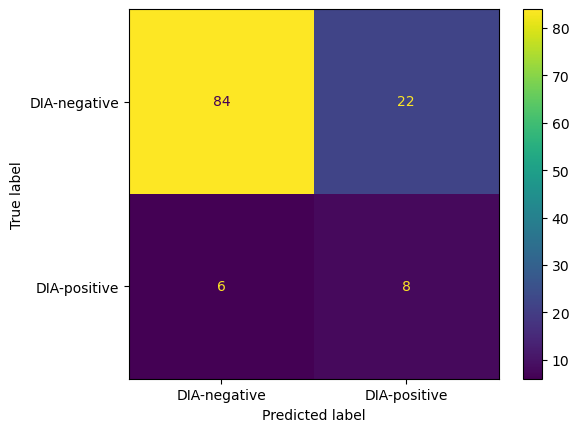

In [153]:
disp = ConfusionMatrixDisplay(confusion_matrix=classic_rf_pca_cm, display_labels=classes)
disp.plot()

In [154]:
print("f1-score is:", f1_score(y_pca_preds_rf, y_test))
print("accuracy is:", accuracy_score(y_pca_preds_rf, y_test))
print("")
print(classification_report(y_pca_preds_rf, y_test))

f1-score is: 0.36363636363636365
accuracy is: 0.7666666666666667

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       106
           1       0.27      0.57      0.36        14

    accuracy                           0.77       120
   macro avg       0.60      0.68      0.61       120
weighted avg       0.86      0.77      0.80       120



### Scaled dataset

In [75]:
# start with logistic regression
scaled_lr = LogisticRegression()
scaled_lr.fit(df_train_scaled, y_train)

LogisticRegression()

In [76]:
# get predictions
scaled_y_preds_lr = scaled_lr.predict(df_test_scaled)

In [77]:
# plot a confusion matrix
scaled_lr_cm = confusion_matrix(scaled_y_preds_lr, y_test)
scaled_lr_cm

array([[82, 23],
       [ 8,  7]], dtype=int64)

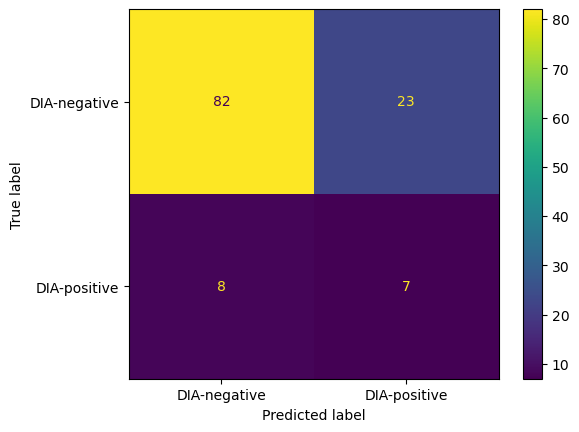

In [78]:
classes = ["DIA-negative", "DIA-positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=scaled_lr_cm, display_labels=classes)
disp.plot()

In [94]:
print("f1-score is:", f1_score(scaled_y_preds_lr, y_test))
print("accuracy is:", accuracy_score(scaled_y_preds_lr, y_test))
print("")
print(classification_report(scaled_y_preds_lr, y_test))

f1-score is: 0.3111111111111111
accuracy is: 0.7416666666666667

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       105
           1       0.23      0.47      0.31        15

    accuracy                           0.74       120
   macro avg       0.57      0.62      0.58       120
weighted avg       0.83      0.74      0.77       120



In [80]:
# continue with random forest
scaled_rf = RandomForestClassifier()
scaled_rf.fit(df_train_scaled, y_train)

RandomForestClassifier()

In [81]:
scaled_y_preds_rf = scaled_rf.predict(df_test_scaled)

In [82]:
scaled_rf_cm = confusion_matrix(scaled_y_preds_rf, y_test)
scaled_rf_cm

array([[87, 19],
       [ 3, 11]], dtype=int64)

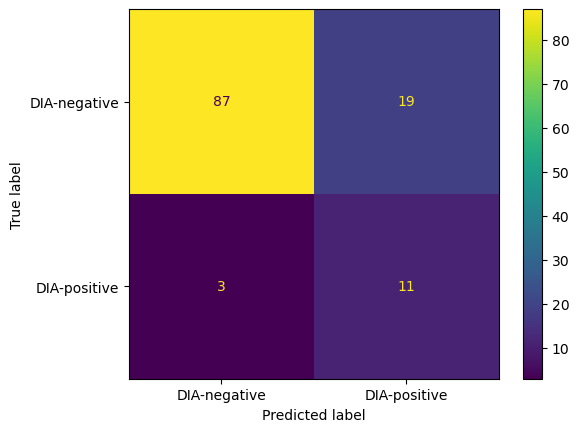

In [83]:
classes = ["DIA-negative", "DIA-positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=scaled_rf_cm, display_labels=classes)
disp.plot()

In [95]:
print("f1-score is:", f1_score(scaled_y_preds_rf, y_test))
print("accuracy is:", accuracy_score(scaled_y_preds_rf, y_test))
print("")
print(classification_report(scaled_y_preds_rf, y_test))

f1-score is: 0.5
accuracy is: 0.8166666666666667

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       106
           1       0.37      0.79      0.50        14

    accuracy                           0.82       120
   macro avg       0.67      0.80      0.69       120
weighted avg       0.90      0.82      0.84       120



In [155]:
# we'll move on to PCA
pca_scaled = PCA(n_components=6)
X_train_scaled_pca = pca_scaled.fit_transform(df_train_scaled)
X_test_scaled_pca = pca_scaled.transform(df_test_scaled)

In [156]:
rf_scaled_pca = RandomForestClassifier()
rf_scaled_pca.fit(X_train_scaled_pca, y_train)

RandomForestClassifier()

In [159]:
scaled_y_preds_pca_rf = rf_scaled_pca.predict(X_test_scaled_pca)

In [161]:
scaled_rf_pca_cm = confusion_matrix(scaled_y_preds_pca_rf, y_test)
scaled_rf_pca_cm

array([[88, 20],
       [ 2, 10]], dtype=int64)

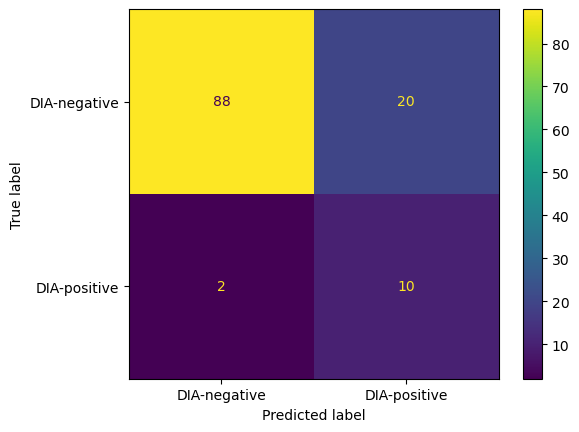

In [162]:
classes = ["DIA-negative", "DIA-positive"]
disp = ConfusionMatrixDisplay(confusion_matrix=scaled_rf_pca_cm, display_labels=classes)
disp.plot()

In [163]:
print("f1-score is:", f1_score(scaled_y_preds_pca_rf, y_test))
print("accuracy is:", accuracy_score(scaled_y_preds_pca_rf, y_test))
print("")
print(classification_report(scaled_y_preds_pca_rf, y_test))

f1-score is: 0.47619047619047616
accuracy is: 0.8166666666666667

              precision    recall  f1-score   support

           0       0.98      0.81      0.89       108
           1       0.33      0.83      0.48        12

    accuracy                           0.82       120
   macro avg       0.66      0.82      0.68       120
weighted avg       0.91      0.82      0.85       120



## Feature extraction
We want to extract features as well to build an intuition around the model and gain insights into what are the factors that lead to DIA conditions.

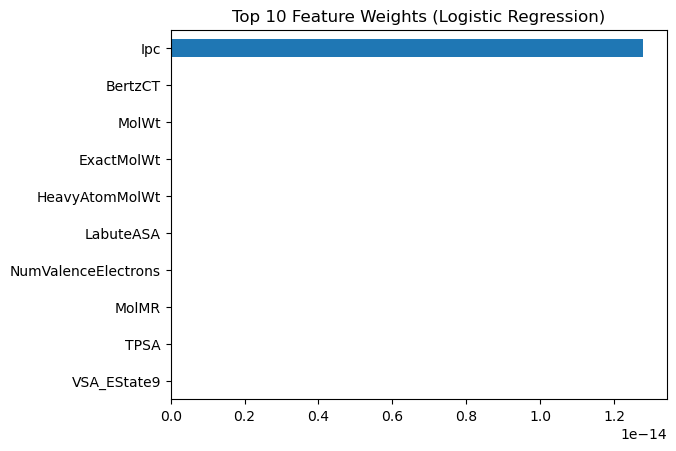

In [98]:
# get the feature importance for LR with original data
lr_coefs = pd.Series(lr.coef_[0], index=X_train.columns)
lr_coefs.abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Weights (Logistic Regression)")
plt.gca().invert_yaxis()

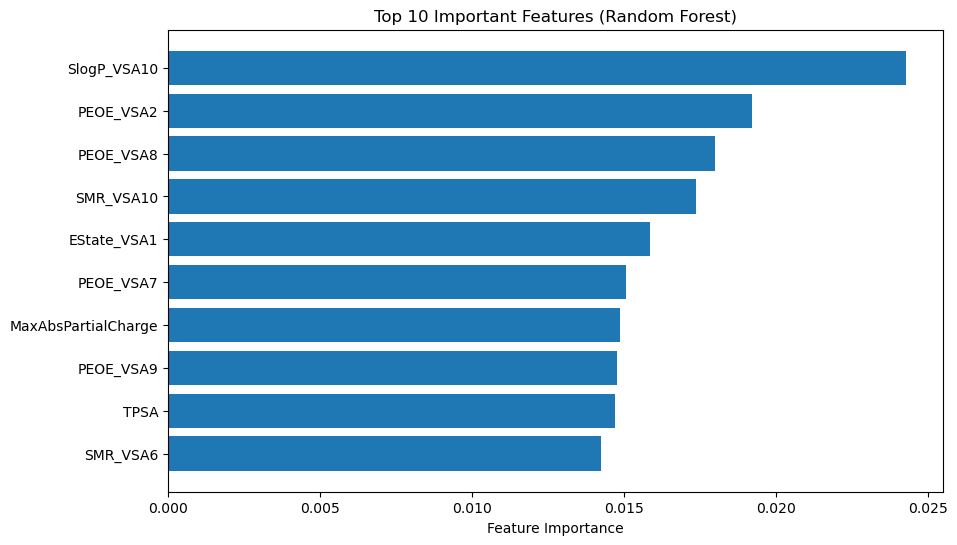

In [101]:
rf_importances = rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(10), rf_importances[sorted_idx[:10]])
plt.yticks(range(10), [X_train.columns[i] for i in sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

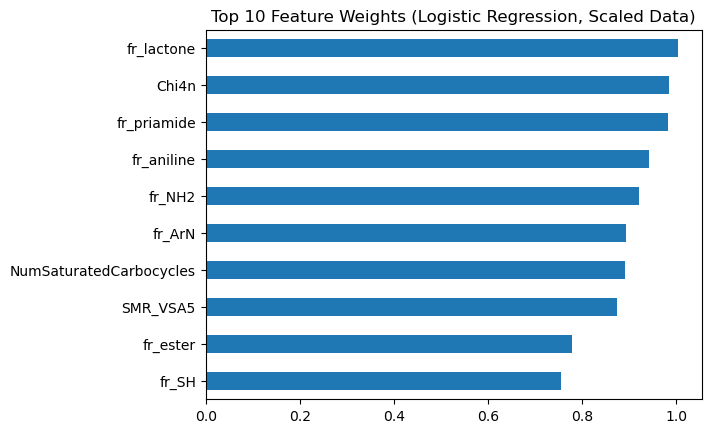

In [102]:
# get the feature importance for LR with scaled data
scaled_lr_coefs = pd.Series(scaled_lr.coef_[0], index=X_train.columns)
scaled_lr_coefs.abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Weights (Logistic Regression, Scaled Data)")
plt.gca().invert_yaxis()

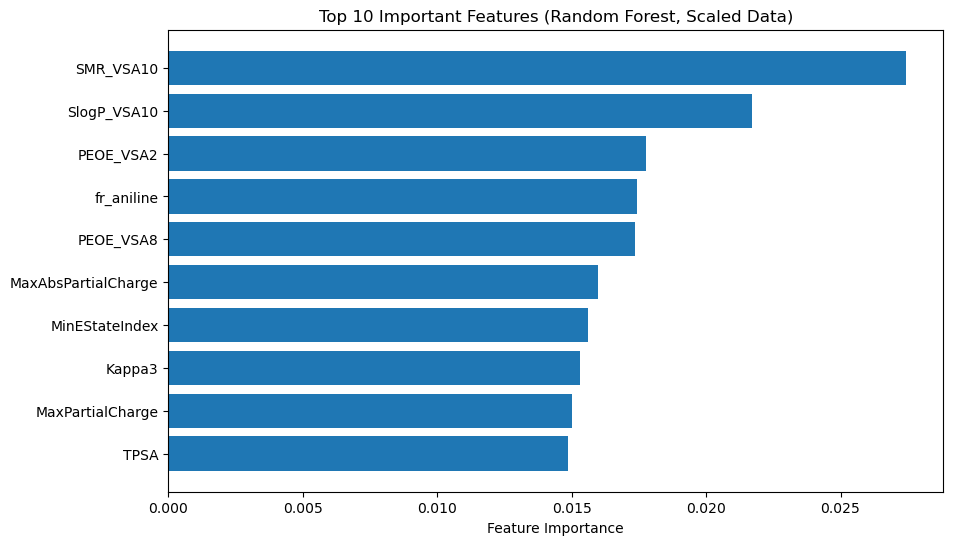

In [103]:
scaled_rf_importances = scaled_rf.feature_importances_
sorted_idx = np.argsort(scaled_rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(10), scaled_rf_importances[sorted_idx[:10]])
plt.yticks(range(10), [X_train.columns[i] for i in sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest, Scaled Data)")
plt.gca().invert_yaxis()
plt.show()

### 🔍 Feature Importance Insights

To gain insight into which molecular descriptors contribute most to the prediction of DIA conditions, we extracted and visualized feature importances from both **Logistic Regression** and **Random Forest** classifiers, using both the original and scaled datasets.

#### 🧪 Logistic Regression:
- On the **original (unscaled) dataset**, the feature `Ipc` dominated, but the coefficients were extremely small (~1e-14), indicating numerical instability or weak signal in raw scale.
- On the **scaled dataset**, the model identified interpretable and chemically relevant features like:
  - `fr_lactone`, `fr_aniline`, `fr_NH2`, and `fr_ArN` - substructure fingerprints related to functional groups.
  - `Chi4n` and `SMR_VSA5`, which reflect topological and surface-related properties.

#### 🌳 Random Forest:
- On the **original dataset**, the most important features included:
  - `SlogP_VSA10`, `PEOE_VSA2/8`, and `SMR_VSA10` - descriptors related to hydrophobicity, partial charge, and molecular refractivity.
  - `MaxAbsPartialCharge` and `TPSA` - electronic and polar surface features.
- On the **scaled dataset**, results were consistent but refined, with `SMR_VSA10`, `SlogP_VSA10`, and `fr_aniline` emerging as top contributors.

#### 🧠 Observations:
- Both models consistently identified **VSA and EState descriptors** (surface area, partial charge, hydrophobicity) as strong predictors.
- **Substructure fingerprints** gained more importance when the data was scaled - possibly due to improved comparability across binary and continuous ranges.
- Classical models already point to chemically interpretable features, validating their utility as a baseline.

These insights not only guide interpretation but also set a reference for evaluating model decisions in future hybrid or quantum experiments.


# ✅ Classical Benchmark Complete

We’ve successfully established a baseline using classical machine learning models and extracted meaningful insights from the feature importances.

- **Random Forest** and **Logistic Regression** both identified chemically relevant descriptors, such as partial charge, surface area, and substructure fingerprints, as top contributors to DIA prediction.
- Scaling the data had a notable effect on model behavior and interpretability, especially for sparse binary features.
- These classical models provide a strong baseline in both performance and explainability, helping us frame what improvements future approaches must deliver.


In the next notebook, we explore **quantum machine learning** techniques to test whether hybrid or fully quantum models can match or surpass these classical baselines, both in predictive power and model insight.
